In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import nc_time_axis 
import cftime

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import proplot as pplt

import warnings
warnings.filterwarnings('ignore')

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
# to set
r_sulfur =  ['12', 
             '13', 
             '14']
r_over =  ['1', 
           '2', 
           '3'
          ]
start_sulfur = 2015
end_sulfur = 2249
end_I = 2062
end_II = 2150
end_III = 2249

In [3]:
scratch = '..'
archive = '..'
dir_to_files = f'{scratch}Roland_gen_aer/data/'
dir_input = dir_to_files +'input/'
dir_simu = f'{archive}CNRM_runs/RE_analysis/manual/belenos_files/'
dir_hist = f'{archive}CNRM_runs/RE_analysis/manual/belenos_files/'
dir_sulfur = f'{archive}CNRM_runs/NER_analysis/ssp534-sulfur/'
dir_over = f'{archive}CNRM_runs/NER_analysis/ssp534-over/'
dir_piControl=f'{archive}CNRM_runs/NER_analysis/piControl/'
dir_old = f'{archive}CNRM_runs/NER_analysis/ssp534-over/former_model_version/'

In [4]:
params = ['tas']
nbparams = len(params) 


In [5]:
def check_time_bounds(data:xr.Dataset):
    return data.drop('time_bounds') if 'time_bounds' in data.data_vars else data

def check_lat_lon(data):
    if 'longitude' in data.dims:
        data = data.rename({'longitude': 'lon'})
    if 'latitude' in data.dims:
        data = data.rename({'latitude': 'lat'})
    return data


# area weighting and average calcualtion
def field_avg_2(data):
    import numpy
    import xarray
    if isinstance(data, xarray.Dataset):
        _das = [data.get(_var) for _var in data.data_vars]; _to_ds = True;
    elif isinstance(data, xarray.DataArray):
        _das = [data]; _to_ds = False;
    else:
        raise TypeError('Input data type should either be a Dataset or a DataArray from the xarray module.')
    _weights = numpy.cos(numpy.deg2rad(data.lat)); _weights.name = 'weights';
    _avgs = []
    for _da in _das:
        _avgs.append(check_lat_lon(_da).weighted(_weights).mean(('lon', 'lat'), keep_attrs = True))
    return xarray.merge(_avgs) if _to_ds else _avgs[0]

def change_T_unit(df):
## turn Fahrenheit? to degC
    try:
        var = 'tas'
        if df[var].min().values > 40 and df[var].max().values > 60:
            df[var] = df[var] - 273.15
    except:
        df = df
    return df

In [6]:
#load in data
# turn from monthly mean to yearly average
# merge with historical data for smooth 10 year rolling mean
data = dict()
over=dict()
sulf=dict()
    
for exp in ['ssp126', 'ssp534-over', 'historical', 'ssp534-sulfur']:
    if exp == 'ssp534-over':
        ds =[]
        for i in range(0, nbparams):
            for mem in r_over:
                over[mem] = xr.open_mfdataset(f'{dir_over}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2/merged/{params[i]}_Amon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                           , engine="netcdf4").groupby('time.year').mean('time')
            over_all = xr.concat([over['1'], over['2'], over['3']], dim='member')
            ds.append(over_all)
        over_ssp534 = xr.merge(ds)
        
    
# load in historic data to get smooth 10year rolling mean at the start of the future simulations
    elif exp == 'historical':
        ds =[]
        for i in range(0, nbparams):
            over = xr.open_mfdataset(f'{dir_simu}{params[i]}_Amon_*{exp}*_gr_185001-201412.nc'
                                                             , engine="netcdf4").drop('time_bounds').groupby('time.year').mean('time')
            ds.append(over)
        hist = xr.merge(ds)

    elif exp == 'ssp534-sulfur':
        ds=[]
        for i in range(0, nbparams):
            for mem in r_sulfur:
                sulf[mem] = xr.open_mfdataset(f'{dir_sulfur}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2*/merged/{params[i]}_Amon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                                             , engine="netcdf4").groupby('time.year').mean('time')
            sulf_all = xr.concat([sulf['12'], sulf['13'], sulf['14']], dim='member')
            ds.append(sulf_all)
        over_sulfur = xr.merge(ds)

data['ssp534'] = xr.merge([over_ssp534, hist])
data['sulfur']= xr.merge([over_sulfur, hist])


old_1 = xr.open_mfdataset(f'{dir_old}tas_Amon_CNRM-ESM2-1_ssp534-over_r1i1p1f2_gr_201501-210012.nc',
                          engine="netcdf4").groupby('time.year').mean('time')
old_2 = xr.open_mfdataset(f'{dir_old}tas_Amon_CNRM-ESM2-1_ssp534-over_r1i1p1f2_gr_210101-229912.nc',
                          engine="netcdf4").groupby('time.year').mean('time').sel(year=slice(2101, 2249))


data['ssp534_old'] = xr.merge([old_1, old_2, hist])


# get co2 concentration data
co2 = xr.open_mfdataset(f'{dir_over}CNRM-ESM2-1_ssp534-over_r1i1p1f2/merged/co2_Amon_*_g*_201501-224912.nc'
                                                             , engine="netcdf4").groupby('time.year').mean('time')
# select surface pressure levels and convert to ppm
co2_ = co2.sel(plev=slice(100000, 70000)).mean('plev').mean(('lat', 'lon')) * 1000000


## SAI magnitude

In [7]:
SAI = pd.read_csv(f'{scratch}/NER_analysis/data/aod_times2_5.csv').drop({'Unnamed: 0'}, axis=1)

### For temperature

In [8]:
data_global_mean=dict()

for scen in ['ssp534', 'sulfur', 'ssp534_old']:
    # area weighting
    data_weigh = field_avg_2(data[scen]) 

    data_mov = data_weigh.rolling(year=10).mean()

    # turn Fahrenheit into °C
    data_global_mean[scen] = change_T_unit(data_mov)
    

In [10]:
T_to_normalize = data_global_mean['ssp534'].mean('member').sel(year=slice(1860,1900)).mean('year')['tas'].values.item()
rnet=dict()
rnet_short=dict()
data_norm=dict()
for scen in [ 'ssp534', 'sulfur', 'ssp534_old']:
    #normalize tas
    data_norm[scen] = data_global_mean[scen]['tas'] - T_to_normalize
    

# Plot

## Plot resubmission

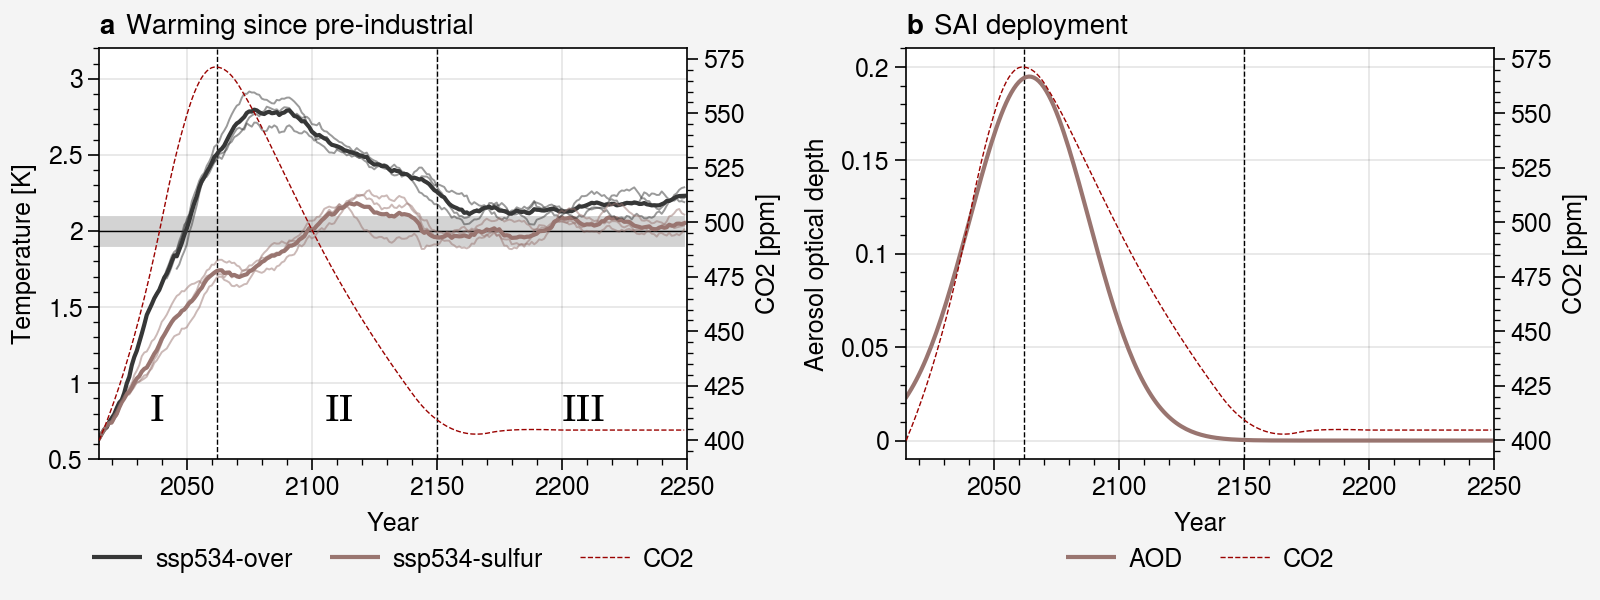

In [14]:
fig, axs = pplt.subplots(ncols=2, nrows=1, refwidth=1.7, figsize=(8, 3), sharey=False, sharex=False)

axes = [axs, axs.twinx()]

# Temperature

axs[0].plot(list(range(1850, 2249+1)),data_norm['ssp534'].mean('member'), label = 'ssp534-over', color='dark gray')
axs[0].plot(list(range(1850, 2249+1)),data_norm['sulfur'].mean('member'), label = 'ssp534-sulfur', color='red gray')
axes[1].plot(list(range(2015, 2249+1)), co2_['co2'], color='deep red', linestyle='--', lw=0.5, label = 'CO2')
axs[0].legend(frameon=False, 
               loc='b'
#               loc='ur'
             )

axs[0].plot(list(range(1850, 2249+1)),data_norm['ssp534'].sel(member=0), color='dark gray', alpha=0.5, lw=.7)
axs[0].plot(list(range(1850, 2249+1)),data_norm['ssp534'].sel(member=1), color='dark gray', alpha=0.5, lw=.7)
axs[0].plot(list(range(1850, 2249+1)),data_norm['ssp534'].sel(member=2), color='dark gray', alpha=0.5, lw=.7)

axs[0].plot(list(range(1850, 2249+1)),data_norm['sulfur'].sel(member=0), color='red gray', alpha=0.5, lw=.7)
axs[0].plot(list(range(1850, 2249+1)),data_norm['sulfur'].sel(member=1), color='red gray', alpha=0.5, lw=.7)
axs[0].plot(list(range(1850, 2249+1)),data_norm['sulfur'].sel(member=2), color='red gray', alpha=0.5, lw=.7)

axs[0].hlines(2,1850, 2249+1, lw = 0.5, color='black')
axs[0].vlines(2062,0.5, 3.2, lw = 0.5, ls = '--', color='black')
axs[0].vlines(2150,0.5, 3.2, lw = 0.5, ls = '--', color='black')

axs[0].fill_between(list(range(1850, 2249+1)),1.9, 2.1, color='lightgray')


axs[0].format(
    xlabel='Year', ylabel='Temperature [K]', ylim=(0.5, 3.2), xlim=(2015, 2250), 
    title='Warming since pre-industrial', titleloc='l'
)
axes[1].format(
    ylabel='CO2 [ppm]'
)

axs[0].text(2035, 0.75, 'I', size='x-large', family='serif')
axs[0].text(2105, 0.75, 'II', size='x-large', family='serif')
axs[0].text(2200, 0.75, 'III', size='x-large', family='serif')


# AOD

axs[1].plot(np.arange(2015,2249+1),SAI['AOD'], color='red gray', label ='AOD')
axs[1].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Aerosol optical depth', xlim=(2015, 2250),ylocator=0.05,
    title='SAI deployment', titleloc='l'
)

axs[1].vlines(2062,-0.01, 0.21, lw = 0.5, ls = '--', color='black')
axs[1].vlines(2150,-0.01, 0.21, lw = 0.5, ls = '--', color='black')

axs[1].legend(frameon=False, loc='b')


fig.format(abc=True)

# save
save_name = f'methods_figure.png'
save_dir = f'{scratch}/NER_analysis/plots/resubmission/' 
#pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True) 
fig.savefig(save_dir + save_name, dpi=600)